In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit
from convokit import TextParser, TensorDecomposer, Corpus, download

In [3]:
corpus = Corpus('convokit/tensor_decomposer/experiments/coarse-discourse-subset')

In [6]:
convo_df = corpus.get_conversations_dataframe()

In [11]:
dis_8 = 0
for convo_id in convo_df[convo_df['meta.longest_path'] >= 8].index:
    convo = corpus.get_conversation(convo_id)
    if convo.get_chronological_utterance_list()[7].meta['disagreement'] == 1:
        dis_8 += 1

In [12]:
dis_8

127

In [14]:
td_disgmt = TensorDecomposer(feature_set=['annot-dict-{}'.format(idx) for idx in range(1, 8+1)], 
                      obj_type="conversation", tensor_func='tensortools-ncp-bcd', rank=9)

In [17]:
td_disgmt.fit(corpus, selector=lambda convo: convo.meta['longest_path'] >= 8 and 
              convo.get_chronological_utterance_list()[7].meta['disagreement'] == 1)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.8087989831728745, improvement inf.
NCP_BCD: iteration 2, objective 0.7814420251157779, improvement 0.027356958057096592.
NCP_BCD: iteration 3, objective 0.7653434152961355, improvement 0.016098609819642395.
NCP_BCD: iteration 4, objective 0.7464088282451757, improvement 0.01893458705095974.
NCP_BCD: iteration 5, objective 0.722309047328254, improvement 0.024099780916921776.
NCP_BCD: iteration 6, objective 0.6959933183736855, improvement 0.026315728954568463.
NCP_BCD: iteration 7, objective 0.6768642029779891, improvement 0.019129115395696394.
NCP_BCD: iteration 8, objective 0.6649084060541786, improvement 0.011955796923810547.
NCP_BCD: iteration 9, objective 0.6561655983928716, improvement 0.008742807661306973.
NCP_BCD: iteration 10, objective 0.6489913064204145, improvement 0.007174291972457114.
NCP_BCD: iteration 11, objective 0.6435598116201954, improvement 0.005431494800219094.
NCP_BCD: iteration 12,

Directory already exists. Exiting summarize()


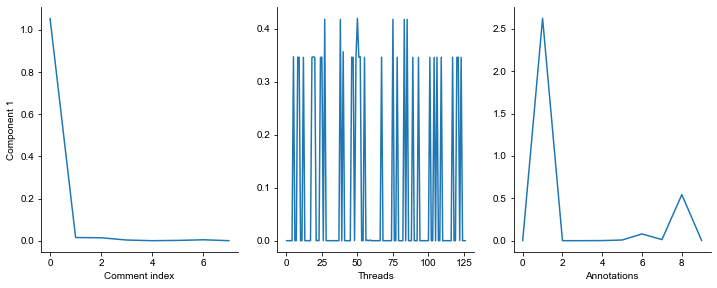

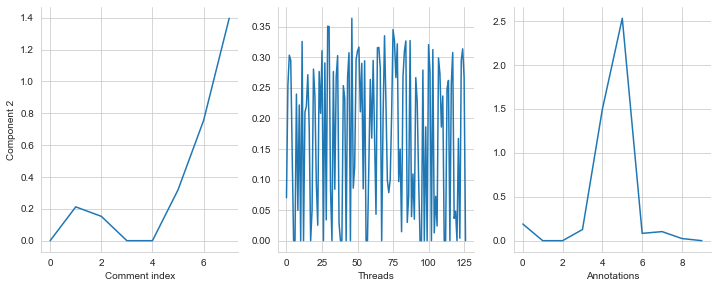

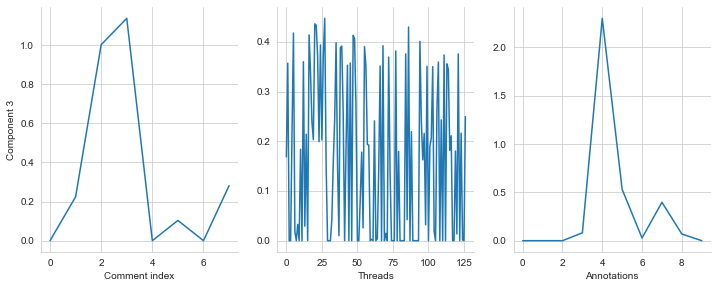

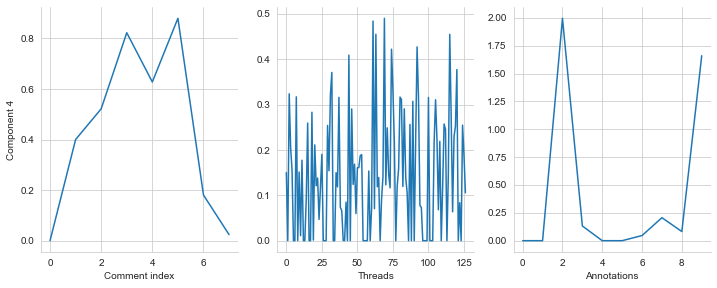

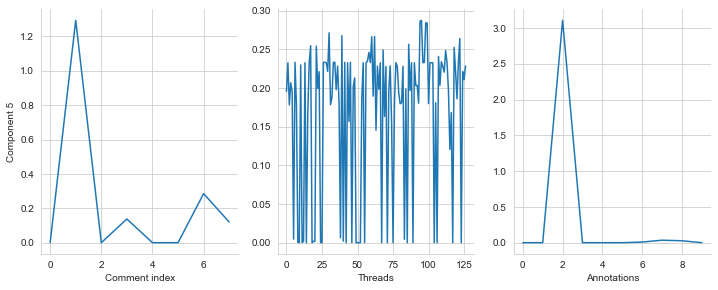

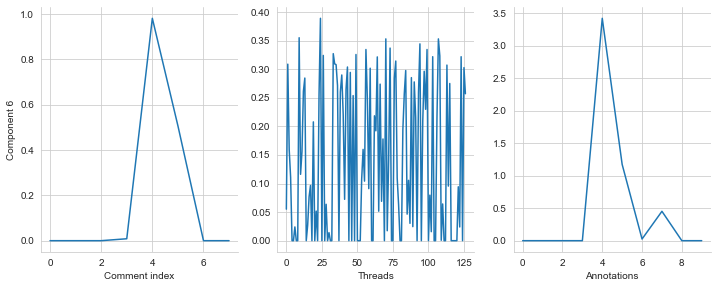

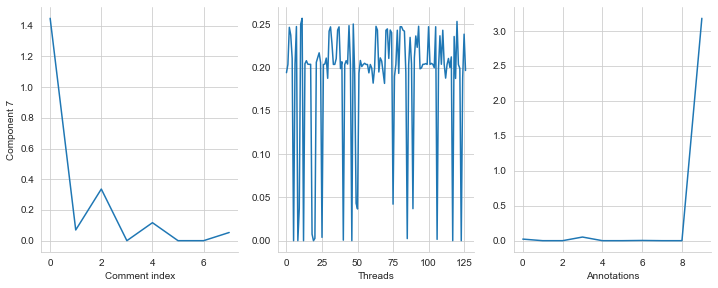

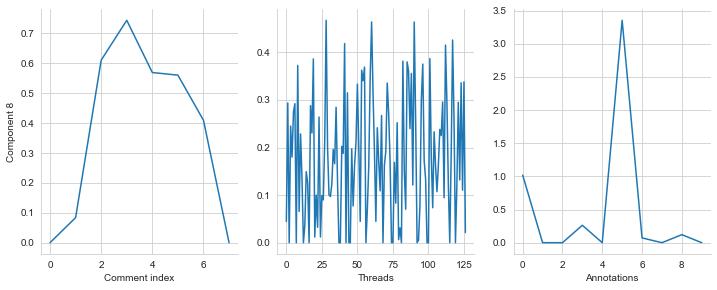

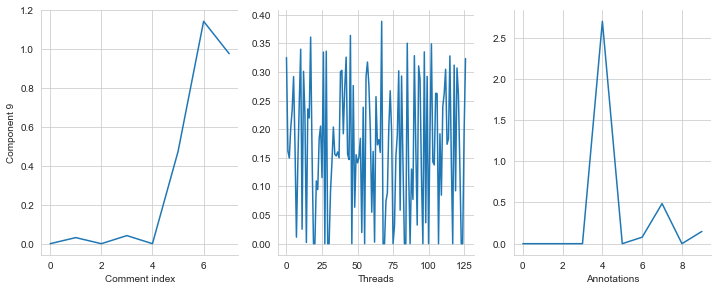

In [19]:
td_disgmt.summarize(corpus, axis_names=['Comment index', 'Threads', 'Annotations'], 
             output_dir='convokit/tensor_decomposer/reports/coarse-discourse', 
             report_title='Coarse discourse', 
             liwc=True)

### Emphasizing disagreements

In [20]:
corpus.random_utterance()

Utterance({'obj_type': 'utterance', '_owner': <convokit.model.corpus.Corpus object at 0x103f25390>, 'meta': {'post_depth': 3, 'majority_type': None, 'majority_link': 't1_d28jr77', 'annotation-types': ['humor', 'elaboration', 'other'], 'annotation-links': ['t1_d28jr77', 't1_d28jr77', 'none'], 'ups': 2, 'annot-dict': {'agreement': 0, 'announcement': 0, 'answer': 0, 'appreciation': 0, 'disagreement': 0, 'elaboration': 1, 'humor': 1, 'negativereaction': 0, 'other': 1, 'question': 0}, 'agreement': 0, 'announcement': 0, 'answer': 0, 'appreciation': 0, 'disagreement': 0, 'elaboration': 1, 'humor': 1, 'negativereaction': 0, 'other': 1, 'question': 0}, '_id': 't1_d294h9v', 'speaker': Speaker({'obj_type': 'speaker', '_owner': <convokit.model.corpus.Corpus object at 0x103f25390>, 'meta': {}, '_id': 'DSP_GC_98'}), 'conversation_id': 't3_4fg0ul', '_root': 't3_4fg0ul', 'reply_to': 't1_d28jr77', 'timestamp': 0, 'text': 'haha, im from philly so being a smart ass is in my blood. '})

In [26]:
annotation_types = ['agreement',
                     'announcement',
                     'answer',
                     'appreciation',
                     'disagreement',
                     'elaboration',
                     'humor',
                     'negativereaction',
                     'other',
                     'question']

In [29]:
no_maj = 0
no_maj_types = {t: 0 for t in annotation_types}
for utt in corpus.iter_utterances():
    if utt.meta['majority_type'] is None:
        no_maj += 1
        for t in utt.meta['annotation-types']:
            no_maj_types[t] += 1

In [31]:
for t in no_maj_types:
    no_maj_types[t] /= 3961

In [32]:
no_maj_types

{'agreement': 0.3082554910376168,
 'announcement': 0.05023983842464024,
 'answer': 0.26861903559707145,
 'appreciation': 0.3006816460489775,
 'disagreement': 0.24640242363039636,
 'elaboration': 0.7020954304468568,
 'humor': 0.18505427922241857,
 'negativereaction': 0.18808381721787426,
 'other': 0.3287048725069427,
 'question': 0.21560212067659681}

In [24]:
no_maj_elab / no_maj

0.7020954304468568

In [23]:
no_maj

3961

### TSNE

In [34]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [35]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=2000, verbose=1)

In [43]:
type_to_trunc = {
    'agreement': 'agmt',
    'announcement': 'anc',
    'answer': 'ans',
    'appreciation': 'appr',
    'disagreement': 'dsgmt',
    'elaboration': 'elab',
    'humor': 'hmr',
    'negativereaction': 'negR',
    'other': 'othr',
    'question': 'qn'
}

In [48]:
import random

In [64]:
for utt in corpus.iter_utterances():
    if utt.meta['majority_type'] is None:
        if 'disagreement' in utt.meta['annotation-types']:
            utt.meta['majority_type_'] = 'disagreement'
        else:
            utt.meta['majority_type_'] = random.choice(utt.meta['annotation-types'])
    else:
        utt.meta['majority_type_'] = utt.meta['majority_type']

In [65]:
for convo in corpus.iter_conversations():
    convo.meta['path'] = '-'.join([type_to_trunc[utt.meta['majority_type_']] for utt in convo.get_chronological_utterance_list()][:8])

In [ ]:
convo.meta['path']

In [66]:
df = corpus.get_conversations_dataframe(lambda c: c.meta['longest_path'] >= 8 and
                                        c.get_chronological_utterance_list()[7].meta['disagreement'] == 1)
projected_threads = tsne.fit_transform(td_disgmt.factors[1])
print(projected_threads.shape)

xs = [x for (x, y) in projected_threads]
ys = [y for (x, y) in projected_threads]

df['x'] = xs
df['y'] = ys

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 127 samples in 0.000s...
[t-SNE] Computed neighbors for 127 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 127 / 127
[t-SNE] Mean sigma: 0.213288
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.464378
[t-SNE] KL divergence after 1000 iterations: 0.353370
(127, 2)


In [67]:
df

,meta.annot-dict-1,meta.annot-dict-10,meta.annot-dict-11,meta.annot-dict-2,meta.annot-dict-3,meta.annot-dict-4,meta.annot-dict-5,meta.annot-dict-6,meta.annot-dict-7,meta.annot-dict-8,meta.annot-dict-9,meta.longest_path,meta.path,meta.subreddit,meta.title,meta.url,x,y
id,,,,,,,,,,,,,,,,,,
t3_1at5ow,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-agmt-qn-ans-dsgmt-dsgmt-dsgmt,askreddit,What book do you think is beautifully written?,https://www.reddit.com/r/AskReddit/comments/1a...,2.604131,-0.293164
t3_24ffw3,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-dsgmt-dsgmt-dsgmt-dsgmt-dsgmt-dsgmt,askreddit,What is one thing you should never give up on?,https://www.reddit.com/r/AskReddit/comments/24...,-1.041959,4.421836
t3_no05m,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-qn-ans-qn-ans-dsgmt-dsgmt,askreddit,Why do you not believe in aliens?,https://www.reddit.com/r/AskReddit/comments/no...,8.779455,0.771824
t3_1mm7er,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-qn-ans-elab-dsgmt-elab-dsgmt,askuk,UK Broadband/ISP subreddits?,https://www.reddit.com/r/AskUK/comments/1mm7er...,5.996558,4.133040
t3_3yvz6m,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-elab-dsgmt-qn-ans-dsgmt-elab,buttcoin,"Do most butters accept global warming? If so, ...",https://www.reddit.com/r/Buttcoin/comments/3yv...,1.988119,0.417150
t3_1tqv73,"{'agreement': 0, 'announcement': 1, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,anc-dsgmt-dsgmt-dsgmt-agmt-agmt-dsgmt-dsgmt,cfb,SI's 'Next Texas Head Coach Bracket' is in the...,https://www.reddit.com/r/CFB/comments/1tqv73/s...,0.772290,-9.832353
t3_12uk6w,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreeme

In [69]:
import plotly.express as px
fig = px.scatter(df, x='x', y='y', hover_data=['meta.path'])
fig.show()

In [60]:
df.shape

(127, 18)